# Sparkify Project Workspace

<b>Tasks:</b>
* Predict churn of customers measured by Cancellation Confirmation page visit

In [1]:
import os
import pandas as pd
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
import sklearn.metrics
from sklearn.metrics import f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
os.listdir()

['user_aggregated_data.html',
 'README.md',
 'mini_sparkify_event_data.json',
 'Sparkify.ipynb',
 '.gitignore',
 '.ipynb_checkpoints',
 '.git',
 'EDA_report.html']

In [3]:
def load_user_data():
    """
    function to load and preprocess the dataset.
    1. convert column names to lowercase
    2. remove rows not connected to any users
    3. remove empty user id records.
    """
    df = pd.read_json('mini_sparkify_event_data.json',lines=True)
    df.columns = [col.lower() for col in df.columns]
    df = df.loc[df['userid'].notna()]
    df = df[~(df['userid']=="")]
    return df
    
def generate_eda_report(df, report_name):
    # generate EDA report if it doesen't exist
    if os.path.exists(f'./{report_name}'):
        print("EDA report already in the folder.")
    else:
        print("Generating EDA report...")
        profile = ProfileReport(df, title="Pandas Profiling Report")
        profile.to_file(report_name)
        print("EDA report saved.")

def convert_dates(df,date_columns):
    #convert unix timestamps to pandas datetime format
    for col in date_columns:
        df[col] = pd.to_datetime(df[col],unit='ms')
        
def get_dates_range(df):
    # get an idea on the date range of the dataset
    date_min = df['ts'].min()
    date_max = df['ts'].max()
    return date_min, date_max

def add_interaction_features(df):
    """
    Use this instead of one hot encoding to avoid adding useless features and possible data leakage.
    """
    df['song_played'] = df['page'] == 'NextSong'
    df['add_playlist'] = df['page'] == 'Add to Playlist'
    df['thumbed_up'] = df['page'] == 'Thumbs Up'
    df['thumbed_down'] = df['page'] == 'Thumbs Down'
    df['added_friend'] = df['page'] == 'Add Friend'
    df['once_premium'] = df['level'] == 'paid'
    # Target variable. Note that cancellation refers to premium and free accounts.
    df['cancelled'] = df['page'] == 'Cancellation Confirmation'
    df['redirected'] = df['status']==307
    df['error'] = df['status']==404
    
    
def add_user_features(df): 
    """
    Get user list with interaction based features.
    """
    users = df.groupby('userid').agg(
    {'userid': [('user_id','max')],
     'page': [('page_count', 'count')], 
     'registration': [('registration_date','max')],
     'ts': [('last_interaction','max')],
     'song_played': [('songs_played', 'sum')],
     'add_playlist': [('songs_playlisted', 'sum')],
     'thumbed_up': [('thumbed_up', 'sum')],
     'thumbed_down': [('thumbed_down', 'sum')],
     'added_friend': [('added_friends', 'sum')],
     'cancelled': [('cancelled', 'max')], 
     'once_premium': [('once_premium', 'max')],
     'location': [('top_location', pd.Series.mode)],
     'gender': [('user_gender',pd.Series.mode)],
     'error': [('error_count', 'count')],
     'redirected': [('redirect_count', 'count')]
    })
    
    users.columns = users.columns.droplevel()
    users = users.reset_index(drop=True)

    users['days_active'] = (users['last_interaction'] - users['registration_date']).dt.days
    users["cancelled"] = users["cancelled"].astype(int)
    users["once_premium"] = users["once_premium"].astype(int)
    return users

def add_session_features(df):
    """
    Get features from every session for every user.
    Average time spent on each session and number of sessions.
    """
    sessions = df.groupby(['userid','sessionid'],as_index=False).agg(
    {'ts': [np.min,np.max]
    })
    sessions.columns = ['userid','sessionid','tmin','tmax']
    sessions['session_length'] = sessions['tmax']-sessions['tmin']
    sessions['time_minutes'] = sessions['session_length'] // np.timedelta64(1, 'm')

    user_sessions = sessions.groupby('userid').agg(
        {'time_minutes': [('time_mean',np.mean)],
         'sessionid': [('session_count', 'count')],
        })

    user_sessions.columns = ['time_mean','session_count']
    user_sessions = user_sessions.reset_index(drop=False)
    user_sessions['time_mean']= user_sessions['time_mean'].astype(int)
    return user_sessions

    
def add_ndays_features(df,n_days): 
    """
     Get user list with interaction based features.
     Will be used in last_n_days function.
    """
    users = df.groupby('userid').agg(
    {'userid': [('user_id','max')],
    'song_played': [(f'{n_days}d_songs_played', 'sum')],
     'add_playlist': [(f'{n_days}d_songs_playlisted', 'sum')],
     'thumbed_up': [(f'{n_days}d_thumbed_up', 'sum')],
     'thumbed_down': [(f'{n_days}d_thumbed_down', 'sum')],
     'added_friend': [(f'{n_days}d_added_friends', 'sum')]
     })
    users.columns = users.columns.droplevel()
    users = users.reset_index(drop=True)
    return users

def add_latest_interaction(df,users):
    """ 
    get the time of last interaction for each user
    """
    user_last_interaction = users[['user_id','last_interaction']]
    df = df.merge(user_last_interaction, left_on='userid', right_on='user_id').drop('user_id',axis=1)
    df['timedelta'] = (df['ts'] - df['last_interaction']).dt.days
    return df

def last_n_days(df,n_days):
    """
    filter the dataset to last n_days and obtain features sepcified in add_ndays_features function.
    """
    df_filtered = df.loc[df['timedelta']>=(-n_days)]
    df_filtered = add_ndays_features(df_filtered ,n_days)
    return df_filtered

def merge_ndays_features(users_table, feat_tables):
    """
    Merge the n_days tables with the main users table
    """
    for table in feat_tables:
        users_table = users_table.merge(table, left_on='user_id', right_on='user_id',
                         how='left', suffixes=('', '_y'))
        users_table.drop(users_table.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)
    return users_table

def hyperopt_tuning(X,y):
    """
    Tune the hyperparameters of the xgboost model.
    evaluates optimum of max_depth, colsample_bytree and gamma.
    """
    def objective(params):
        params = {
            'max_depth': int(params['max_depth']),
            'gamma': "{:.3f}".format(params['gamma']),
            'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
            'min_child_weight': '{:.3f}'.format(params['min_child_weight']),
            'subsample': '{:.3f}'.format(params['subsample']),
            'gamma': '{:.3f}'.format(params['gamma']),
        }

        clf = xgb.XGBClassifier(
            n_estimators=250,
            learning_rate = 0.2,
            n_jobs=4,
            **params
        )

        score = cross_val_score(clf, X, y, scoring="roc_auc", cv=StratifiedKFold()).mean()
        print("Score: {:.3f} params {}".format(score, params))
        return score

    space = {
        'max_depth': hp.quniform('max_depth', 5, 16, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
        'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
        'subsample':        hp.uniform('subsample', 0.8, 1),
        'gamma': hp.uniform('gamma', 0.0, 0.5)
    }

    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=25)
    return best

# Data Load & automated EDA

In [4]:
# Load user data
df = load_user_data()

# Save automated EDA report to current directory.
# Report identified empty user ids that were already cleaned in load_user_data function.
generate_eda_report(df,report_name='EDA_report.html')

# Convert unix timestamps to pandas datetime format
convert_dates(df,date_columns=['ts','registration'])

# Drop unncessary columns
df = df.drop(['auth','method','useragent','lastname','firstname','song'], axis=1)

# Get date range of the dataset
date_min, date_max= get_dates_range(df)
print(f"Dataset interactions date range: {date_max-date_min}")

EDA report already in the folder.
Dataset interactions date range: 63 days 01:09:19


# Manual EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278154 entries, 0 to 286499
Data columns (total 12 columns):
ts               278154 non-null datetime64[ns]
userid           278154 non-null object
sessionid        278154 non-null int64
page             278154 non-null object
status           278154 non-null int64
level            278154 non-null object
iteminsession    278154 non-null int64
location         278154 non-null object
registration     278154 non-null datetime64[ns]
gender           278154 non-null object
artist           228108 non-null object
length           228108 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(3), object(6)
memory usage: 27.6+ MB


In [6]:
df.head(3)

,ts,userid,sessionid,page,status,level,iteminsession,location,registration,gender,artist,length
0,2018-10-01 00:01:57,30,29,NextSong,200,paid,50,"Bakersfield, CA",2018-09-28 22:22:42,M,Martha Tilston,277.89016
1,2018-10-01 00:03:00,9,8,NextSong,200,free,79,"Boston-Cambridge-Newton, MA-NH",2018-09-30 18:20:30,M,Five Iron Frenzy,236.09424
2,2018-10-01 00:06:34,30,29,NextSong,200,paid,51,"Bakersfield, CA",2018-09-28 22:22:42,M,Adam Lambert,282.82730


In [7]:
# encode categorical features. 
# To avoid high data sparsity and higher training times, label encoder was used instead of one hot.
LE = LabelEncoder()
df['location'] = LE.fit_transform(df['location'])
# Note that in some of the real life modelling, gender feature can be considered discriminatory and unfair.
df['gender'] = LE.fit_transform(df['gender'])
df.head(5)

,ts,userid,sessionid,page,status,level,iteminsession,location,registration,gender,artist,length
0,2018-10-01 00:01:57,30,29,NextSong,200,paid,50,8,2018-09-28 22:22:42,1,Martha Tilston,277.89016
1,2018-10-01 00:03:00,9,8,NextSong,200,free,79,12,2018-09-30 18:20:30,1,Five Iron Frenzy,236.09424
2,2018-10-01 00:06:34,30,29,NextSong,200,paid,51,8,2018-09-28 22:22:42,1,Adam Lambert,282.82730
3,2018-10-01 00:06:56,9,8,NextSong,200,free,80,12,2018-09-30 18:20:30,1,Enigma,262.71302
4,2018-10-01 00:11:16,30,29,NextSong,200,paid,52,8,2018-09-28 22:22:42,1,Daft Punk,223.60771


In [8]:
# list distinct user actions. 
# This is an important column that will be the main source for feature engineering.
df['page'].value_counts()

NextSong                     228108
Thumbs Up                     12551
Home                          10082
Add to Playlist                6526
Add Friend                     4277
Roll Advert                    3933
Logout                         3226
Thumbs Down                    2546
Downgrade                      2055
Settings                       1514
Help                           1454
Upgrade                         499
About                           495
Save Settings                   310
Error                           252
Submit Upgrade                  159
Submit Downgrade                 63
Cancellation Confirmation        52
Cancel                           52
Name: page, dtype: int64

---
# Feature Engineering ideas:
**activity**
* number of interactions with the platform
* number of songs played
* number of thumbs Up,thumbs down total thumbs up/total songs played
* number of friends added
* number of songs added to a playlist

**time deltas**
* days since registration
* days since last interaction
* dates between registration and last interaction

**session features**
* average session time
* number of sessions

**target feature**
* Cancellation confirmation

In [9]:
# Add features based on 'page' column
add_interaction_features(df)

In [10]:
# Create a new table with features based on aggregated interactions by userid
users = add_user_features(df)

In [11]:
# Add latest interaction feature
df = add_latest_interaction(df,users)

In [12]:
# Filter interactions for specific timeframe
last_week = last_n_days(df,7)
last_month = last_n_days(df,30)
last_threemonths = last_n_days(df,90)

# Create a list of tables with time related features
feat_tables = [last_week,last_month,last_threemonths]

In [13]:
# Join the time related features with the user table
users = merge_ndays_features(users, feat_tables)

In [14]:
# Add more features based on the aggregate results
users['playlisted_ratio'] = users['songs_playlisted']/(users['songs_played']+1)
users['thumbed_up_ratio'] = users['thumbed_up']/(users['songs_played']+1)
users['thumbed_down_ratio'] = users['thumbed_down']/(users['songs_played']+1)
users['songs_per_day'] = users['songs_played']/(users['days_active']+1)
users['interactions_per_day'] = users['page_count']/(users['days_active']+1)

In [15]:
# Get rid of n/a values
users= users.fillna(0)

In [16]:
# Adding session related features
session_feat = add_session_features(df)

users = users.merge(session_feat, left_on='user_id', right_on='userid',
                         how='left', suffixes=('', '_y'))

users['inter_per_session']= users['page_count']/users['session_count']
users['sessions_per_day']= users['session_count']/ users['days_active']

In [17]:
users.columns

Index(['user_id', 'page_count', 'registration_date', 'last_interaction',
       'songs_played', 'songs_playlisted', 'thumbed_up', 'thumbed_down',
       'added_friends', 'cancelled', 'once_premium', 'top_location',
       'user_gender', 'error_count', 'redirect_count', 'days_active',
       '7d_songs_played', '7d_songs_playlisted', '7d_thumbed_up',
       '7d_thumbed_down', '7d_added_friends', '30d_songs_played',
       '30d_songs_playlisted', '30d_thumbed_up', '30d_thumbed_down',
       '30d_added_friends', '90d_songs_played', '90d_songs_playlisted',
       '90d_thumbed_up', '90d_thumbed_down', '90d_added_friends',
       'playlisted_ratio', 'thumbed_up_ratio', 'thumbed_down_ratio',
       'songs_per_day', 'interactions_per_day', 'userid', 'time_mean',
       'session_count', 'inter_per_session', 'sessions_per_day'],
      dtype='object')

In [18]:
users.head(3)

,user_id,page_count,registration_date,last_interaction,songs_played,songs_playlisted,thumbed_up,thumbed_down,added_friends,cancelled,...,playlisted_ratio,thumbed_up_ratio,thumbed_down_ratio,songs_per_day,interactions_per_day,userid,time_mean,session_count,inter_per_session,sessions_per_day
0,10,795,2018-09-28 18:31:35,2018-11-19 12:49:48,673.0,9.0,37.0,4.0,12.0,0,...,0.013353,0.054896,0.005935,12.942308,15.288462,10,459,6,132.500000,0.117647
1,100,3214,2018-09-26 17:17:35,2018-11-30 14:15:49,2682.0,61.0,148.0,27.0,49.0,0,...,0.022736,0.055162,0.010063,41.261538,49.446154,100,316,35,91.828571,0.546875
2,100001,187,2018-08-18 21:24:26,2018-10-02 16:36:45,133.0,3.0,8.0,2.0,2.0,1,...,0.022388,0.059701,0.014925,2.955556,4.155556,100001,147,4,46.750000,0.090909


In [19]:
users['cancelled'].value_counts()

0    173
1     52
Name: cancelled, dtype: int64

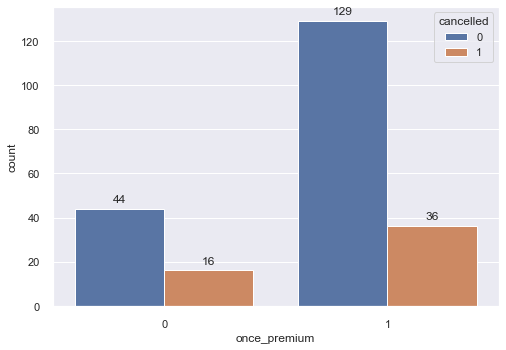

In [20]:
# Customer behavior- premium vs not
# Note similar proprotion of membership cancellations

sns.set(style="darkgrid")
ax = sns.countplot(x="once_premium", data=users,hue='cancelled')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f'{height}',
            ha="center") 
plt.show()

In [21]:
16/44, 36/129

(0.36363636363636365, 0.27906976744186046)

In [22]:
# Limit the analysis to users who subscribed to premium
users_premium = users.loc[users['once_premium']==1]

# select relevant columns
users_final = users_premium[['page_count', 'songs_played','songs_playlisted', 'thumbed_up', 'thumbed_down',
       'added_friends','top_location',
       'user_gender', 'error_count', 'redirect_count', 'days_active',
       '7d_songs_played', '7d_songs_playlisted', '7d_thumbed_up',
       '7d_thumbed_down', '7d_added_friends','playlisted_ratio', 'thumbed_up_ratio', 'thumbed_down_ratio',
       'songs_per_day', 'interactions_per_day','time_mean',
       'session_count','sessions_per_day','cancelled']]

In [23]:
users_final.head(3)

,page_count,songs_played,songs_playlisted,thumbed_up,thumbed_down,added_friends,top_location,user_gender,error_count,redirect_count,...,7d_added_friends,playlisted_ratio,thumbed_up_ratio,thumbed_down_ratio,songs_per_day,interactions_per_day,time_mean,session_count,sessions_per_day,cancelled
0,795,673.0,9.0,37.0,4.0,12.0,51,1,795,795,...,2.0,0.013353,0.054896,0.005935,12.942308,15.288462,459,6,0.117647,0
1,3214,2682.0,61.0,148.0,27.0,49.0,26,1,3214,3214,...,4.0,0.022736,0.055162,0.010063,41.261538,49.446154,316,35,0.546875,0
3,218,195.0,5.0,5.0,0.0,1.0,96,0,218,218,...,0.0,0.025510,0.025510,0.000000,1.211180,1.354037,200,4,0.025000,0


In [24]:
generate_eda_report(users_final, 'user_aggregated_data.html')

EDA report already in the folder.


In [25]:
y = users_final['cancelled']
X = users_final.drop('cancelled',axis=1)

X_train, X_test, y_train, y_test = \
        sklearn.model_selection.train_test_split(X, y, test_size=0.2,random_state=1)

In [26]:
users_final['cancelled'].value_counts()

0    129
1     36
Name: cancelled, dtype: int64

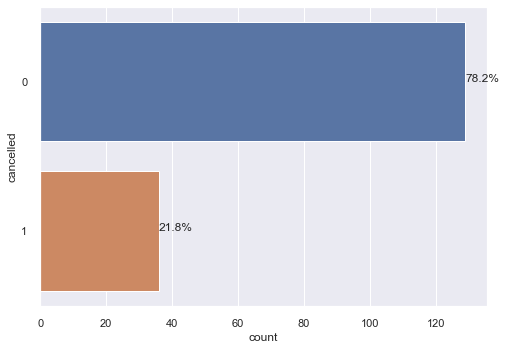

In [27]:
sns.set(style="darkgrid")
ax = sns.countplot(y="cancelled", data=users_final)
total = len(users_final)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y)) 
plt.show()

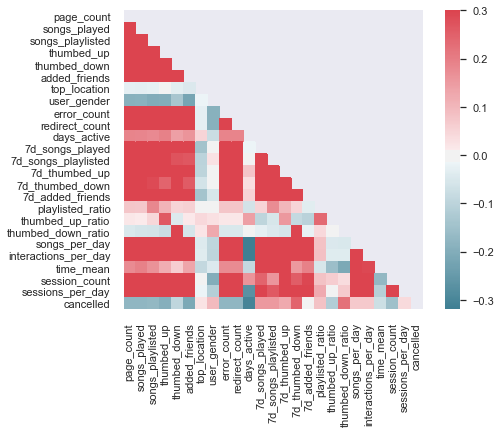

In [28]:
corr = users_final.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap,vmax=.3,center=0, square=True)

In [29]:
clf = RandomForestClassifier(n_estimators=100,random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91        28
           1       0.50      0.40      0.44         5

    accuracy                           0.85        33
   macro avg       0.70      0.66      0.68        33
weighted avg       0.84      0.85      0.84        33



In [30]:
best = hyperopt_tuning(X_train,y_train)
print("Hyperopt estimated optimum {}".format(best))

Score: 0.758 params {'max_depth': 12, 'gamma': '0.317', 'colsample_bytree': '0.575', 'min_child_weight': '5.000', 'subsample': '0.810'}
Score: 0.767 params {'max_depth': 9, 'gamma': '0.162', 'colsample_bytree': '0.898', 'min_child_weight': '4.000', 'subsample': '0.973'}
Score: 0.753 params {'max_depth': 7, 'gamma': '0.061', 'colsample_bytree': '0.665', 'min_child_weight': '3.000', 'subsample': '0.976'}
Score: 0.756 params {'max_depth': 10, 'gamma': '0.002', 'colsample_bytree': '0.440', 'min_child_weight': '3.000', 'subsample': '0.941'}
Score: 0.757 params {'max_depth': 12, 'gamma': '0.305', 'colsample_bytree': '0.837', 'min_child_weight': '1.000', 'subsample': '0.952'}
Score: 0.763 params {'max_depth': 11, 'gamma': '0.249', 'colsample_bytree': '0.456', 'min_child_weight': '6.000', 'subsample': '0.991'}
Score: 0.753 params {'max_depth': 15, 'gamma': '0.287', 'colsample_bytree': '0.815', 'min_child_weight': '5.000', 'subsample': '0.964'}
Score: 0.775 params {'max_depth': 13, 'gamma': '0.

In [31]:
# Instantiate the model
xgb_model = xgb.XGBClassifier(learning_rate=0.05, 
              n_estimators=200,     
                              colsample_bytree= 0.91, 
                              gamma= 0.25, 
                              max_depth= 15, 
                              min_child_weight= 1, 
              objective='binary:logistic', 
              random_state=42)

# fit model to training data
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95        28
           1       0.75      0.60      0.67         5

    accuracy                           0.91        33
   macro avg       0.84      0.78      0.81        33
weighted avg       0.90      0.91      0.90        33



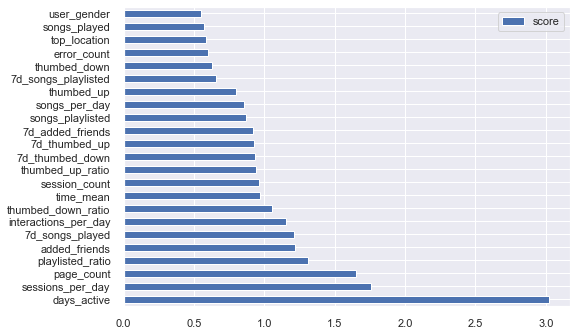

In [32]:
feature_important = xgb_model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh')

In [33]:
# Output visualisation
print('True values:')
print(np.array(y_test))
print()
print('Predicted:')
print(np.array(y_pred))

True values:
[0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0]

Predicted:
[0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0]
